# Eliran Refaeli & Guy Dinar

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer, log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline


%matplotlib inline

1. How many rows we have deleted after the EDA.

# Dataset

In [2]:
dataset = 'https://raw.githubusercontent.com/GuyDinar/PublicRep/main/Classification%20Dataset/home-insurance-raw-data.csv'
df = pd.read_csv(dataset)

## First look

In [3]:
row_s, col_s = df.shape

df.head()

,id,state,postal_code,product,user_id,square_ft,high_risk_dog,has_fire_alarm,has_burglar_alarm,portable_electronics,coast,fire_housing_proximity,previous_policies,user_age,card_type,target
0,2.492010e+18,NM,87043,ho4,-9.160050e+18,NaN,0,True,True,0.0,NaN,5,0,39.0,credit,False
1,8.860750e+17,WI,53715,ho4,-8.929000e+18,NaN,0,True,False,1.0,30.0,1,0,19.0,debit,False
2,5.527290e+18,WI,53211,ho4,-9.015980e+18,NaN,0,True,False,1.0,1.0,1,0,20.0,debit,True
3,6.453400e+18,NM,88012,ho4,-9.060030e+18,NaN,0,True,True,1.0,NaN,1,0,33.0,debit,False
4,-8.836390e+18,AR,72116,ho4,-8.801720e+18,NaN,0,False,False,1.0,NaN,1,0,20.0,debit,False


## Basic info & Describe

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12397 entries, 0 to 12396
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      12397 non-null  float64
 1   state                   12397 non-null  object 
 2   postal_code             12397 non-null  int64  
 3   product                 12397 non-null  object 
 4   user_id                 12397 non-null  float64
 5   square_ft               279 non-null    float64
 6   high_risk_dog           12397 non-null  int64  
 7   has_fire_alarm          12397 non-null  bool   
 8   has_burglar_alarm       12397 non-null  bool   
 9   portable_electronics    11990 non-null  float64
 10  coast                   11242 non-null  float64
 11  fire_housing_proximity  12397 non-null  object 
 12  previous_policies       12397 non-null  int64  
 13  user_age                12315 non-null  float64
 14  card_type               12345 non-null

Fields with nulls:

square_ft, portable_electronics, coast, user_age, card_type

In [5]:
df.describe(include='all')
# Unbalanced Data!!!!!!!!!!! df.target.value_counts() Oversampling / undersampling / give weights

,id,state,postal_code,product,user_id,square_ft,high_risk_dog,has_fire_alarm,has_burglar_alarm,portable_electronics,coast,fire_housing_proximity,previous_policies,user_age,card_type,target
count,1.239700e+04,12397,12397.000000,12397,1.239700e+04,279.000000,12397.0,12397,12397,11990.000000,11242.000000,12397,12397.000000,12315.000000,12345,12397
unique,NaN,21,NaN,3,NaN,NaN,NaN,2,2,NaN,NaN,15,NaN,NaN,3,2
top,NaN,CA,NaN,ho4,NaN,NaN,NaN,True,False,NaN,NaN,1,NaN,NaN,debit,False
freq,NaN,3798,NaN,12127,NaN,NaN,NaN,9395,10721,NaN,NaN,6391,NaN,NaN,7131,12116
mean,-1.303499e+16,NaN,62576.877309,NaN,-9.009474e+18,1457.498208,0.0,NaN,NaN,0.336364,17.839619,NaN,0.237961,31.085668,NaN,NaN
std,5.326267e+18,NaN,32553.186912,NaN,1.237394e+17,728.877297,0.0,NaN,NaN,0.472485,12.128988,NaN,0.527252,10.000254,NaN,NaN
min,-9.221130e+18,NaN,2840.000000,NaN,-9.223350e+18,100.000000,0.0,NaN,NaN,0.000000,0.000000,NaN,0.000000,17.000000,NaN,NaN
25%,-4.604830e+18,NaN,30084.000000,NaN,-9.117380e+18,850.000000,0.0,NaN,NaN,0.000000,4.000000,NaN,0.000000,24.000000,NaN,NaN
50%,-2.537840e+16,NaN,77006.000000,NaN,-9.009450e+18,1350.000000,0.0,NaN,NaN,0.000000,20.000000,NaN,0.000000,29.000000,NaN,NaN
75%,4.593520e+18,NaN,91367.000000,NaN,-8.902650e+18,1907.500000,0.0,NaN,NaN,1.000000,30.000000,NaN,0.000000,35.000000,NaN,NaN


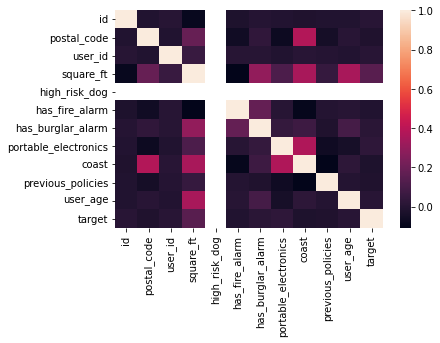

In [6]:
# Correlation
sns.heatmap(df.corr());

Fields to edit:

- has_fire_alarm
- has_burglar_alarm
- card_type

In [7]:
# rows with more than 4 missing columns
df[(df.isnull().sum(axis=1) >= 4)]

,id,state,postal_code,product,user_id,square_ft,high_risk_dog,has_fire_alarm,has_burglar_alarm,portable_electronics,coast,fire_housing_proximity,previous_policies,user_age,card_type,target
16,-8.015960e+17,IA,52246,ho4,-9.029900e+18,NaN,0,False,False,NaN,NaN,2,0,NaN,debit,False
1790,-6.234530e+18,CA,91354,ho4,-8.845690e+18,NaN,0,False,False,NaN,30.0,4,0,NaN,NaN,False
5559,-7.819600e+18,MI,49009,ho4,-9.022010e+18,NaN,0,False,False,NaN,NaN,4,0,NaN,debit,False
6062,2.383860e+18,NV,89122,ho4,-9.071920e+18,NaN,0,False,False,NaN,NaN,2,0,NaN,debit,False
8437,4.784160e+18,OH,43110,ho4,-8.921790e+18,NaN,0,False,False,NaN,NaN,3,0,NaN,debit,False
8605,8.910550e+18,OH,43209,ho4,-8.813950e+18,NaN,0,False,False,NaN,NaN,3,0,NaN,debit,False
8894,2.463720e+18,PA,19380,ho4,-8.809470e+18,NaN,0,False,False,NaN,NaN,4,0,NaN,debit,False
10209,5.736360e+18,TX,77380,ho4,-8.989640e+18,NaN,0,False,False,NaN,30.0,1,0,NaN,NaN,False


# Clean the dataframe

In [8]:
# Remove high_risk_dog because all values are 0
# Remove square_ft because only 279 rows have values
df.drop(columns=['high_risk_dog', 'square_ft'], inplace=True)

In [9]:
# Change booleans to 0 and 1
has_fire_alarm_remap_dict = {True: 1, False: 0}
df.replace({'has_fire_alarm': has_fire_alarm_remap_dict}, inplace=True)

has_burglar_alarm_remap_dict = {True: 1, False: 0}
df.replace({'has_burglar_alarm': has_burglar_alarm_remap_dict}, inplace=True)

In [10]:
# Change nulls to 0
# We don't remove the rows because some of them have target = True.
df.portable_electronics.fillna(0, inplace=True)

# Change nulls to 100 and use bins to change 1,2,3,4,5 to 5
df['coast'] = df['coast'].mask((df['coast'] >= 0) & (df['coast'] < 5), 5)
df.coast.fillna(100, inplace=True)

# Change float to int
df.portable_electronics = df.portable_electronics.astype('int')

In [11]:
# Analyze postal_code
df.postal_code.value_counts()

10016    95
10009    76
78741    76
94103    67
94107    66
         ..
8360      1
49332     1
75961     1
45242     1
79911     1
Name: postal_code, Length: 2565, dtype: int64

In [12]:
df[df.postal_code==10016].state.value_counts()

NY    95
Name: state, dtype: int64

In [13]:
# Remove State - it's basically the postal code
df.drop(columns=['state'], inplace=True)
# Remove id and user_id because they mean nothing in the context of X
df.drop(columns=['id', 'user_id'], inplace=True)

In [14]:
# Analyze values in fire_house_proximity
df.fire_housing_proximity.value_counts(dropna=False)

1     6391
2     3574
3     1616
4      595
5      171
6       27
7        6
7X       3
5X       3
8B       3
5Y       2
4Y       2
8        2
4X       1
6Y       1
Name: fire_housing_proximity, dtype: int64

In [15]:
# Remove rows with bad fire_house_proximity
weird_fire_rows = df.fire_housing_proximity.isin(['8B', '7X', '5X', '5Y', '4Y', '6Y', '4X'])
df.drop(df[weird_fire_rows].index, inplace=True)

# Change float to int
df.fire_housing_proximity = df.fire_housing_proximity.astype('int')

In [16]:
# check policies with no user_age with true Y
df[(df.user_age.isna()) & (df.target==True)]

,postal_code,product,has_fire_alarm,has_burglar_alarm,portable_electronics,coast,fire_housing_proximity,previous_policies,user_age,card_type,target
664,90046,ho4,0,0,0,10.0,1,0,NaN,debit,True
2124,94124,ho4,1,0,0,5.0,1,1,NaN,credit,True
3285,95677,ho4,0,0,0,30.0,2,0,NaN,debit,True
3441,90247,ho4,0,0,0,10.0,3,0,NaN,debit,True


In [17]:
# fill NaN with the average user_age (very little rows so we're not worried about "inserting X into Y")
df.user_age.fillna(df.user_age.mean(), inplace=True)

In [18]:
# Remove rows with Nan card_type
card_type_null_rows = df.card_type.isna()
df.drop(df[card_type_null_rows].index, inplace=True)

In [19]:
# Rename column "Product"
df.rename(columns={'product':'policy_type'}, inplace=True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12331 entries, 0 to 12396
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   postal_code             12331 non-null  int64  
 1   policy_type             12331 non-null  object 
 2   has_fire_alarm          12331 non-null  int64  
 3   has_burglar_alarm       12331 non-null  int64  
 4   portable_electronics    12331 non-null  int64  
 5   coast                   12331 non-null  float64
 6   fire_housing_proximity  12331 non-null  int64  
 7   previous_policies       12331 non-null  int64  
 8   user_age                12331 non-null  float64
 9   card_type               12331 non-null  object 
 10  target                  12331 non-null  bool   
dtypes: bool(1), float64(2), int64(6), object(2)
memory usage: 1.0+ MB


In [21]:
df.describe(include='all')

,postal_code,policy_type,has_fire_alarm,has_burglar_alarm,portable_electronics,coast,fire_housing_proximity,previous_policies,user_age,card_type,target
count,12331.000000,12331,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331.000000,12331,12331
unique,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2
top,NaN,ho4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,debit,False
freq,NaN,12068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7120,12051
mean,62658.867732,NaN,0.758170,0.134701,0.325602,26.188063,1.763604,0.237207,31.081517,NaN,NaN
std,32525.221125,NaN,0.428209,0.341418,0.468618,25.973964,0.979593,0.525364,9.962829,NaN,NaN
min,2840.000000,NaN,0.000000,0.000000,0.000000,5.000000,1.000000,0.000000,17.000000,NaN,NaN
25%,30093.000000,NaN,1.000000,0.000000,0.000000,5.000000,1.000000,0.000000,24.000000,NaN,NaN
50%,77007.000000,NaN,1.000000,0.000000,0.000000,25.000000,1.000000,0.000000,29.000000,NaN,NaN
75%,91385.500000,NaN,1.000000,0.000000,1.000000,30.000000,2.000000,0.000000,35.000000,NaN,NaN


In [22]:
# Use get_dummies() to take care of two columns with small number of values
df = pd.get_dummies(df, columns=['policy_type', 'card_type'])

In [23]:
# target_weight = np.where(df['target']==True, true_weight, 1)

In [24]:
df

,postal_code,has_fire_alarm,has_burglar_alarm,portable_electronics,coast,fire_housing_proximity,previous_policies,user_age,target,policy_type_ho3,policy_type_ho4,policy_type_ho6,card_type_credit,card_type_debit,card_type_prepaid
0,87043,1,1,0,100.0,5,0,39.0,False,0,1,0,1,0,0
1,53715,1,0,1,30.0,1,0,19.0,False,0,1,0,0,1,0
2,53211,1,0,1,5.0,1,0,20.0,True,0,1,0,0,1,0
3,88012,1,1,1,100.0,1,0,33.0,False,0,1,0,0,1,0
4,72116,0,0,1,100.0,1,0,20.0,False,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12392,78754,0,0,0,30.0,1,1,52.0,False,0,1,0,0,1,0
12393,75215,1,1,1,30.0,2,0,46.0,True,0,1,0,0,1,0
12394,77087,0,1,1,20.0,1,0,24.0,False,0,1,0,1,0,0
12395,78704,1,0,1,30.0,1,0,36.0,False,0,1,0,0,1,0


In [25]:
row_e, col_e = df.shape

In [26]:
deleted_rows = row_s - row_e

print(f'We deleted {deleted_rows} rows')

We deleted 66 rows


--------------------------------------------------------------------

Chosen metrics: f1

Chosen models: Random Forest + Logistic regression

In [27]:
# doc
note = pd.DataFrame(columns=['Model', 'F1'])

# Pipeline

In [28]:
# pipeline - creating

def pipi(df, model, **config):
  X = df.drop(columns=['target'])
  y = df.target
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

  clf = model(**config)

  step = [('model', clf)]

  pip = Pipeline(step)
  pip.fit(X_train, y_train)
  y_pred = pip.predict(X_test)
  
  f1 = f1_score(y_true=y_test, y_pred=y_pred)

  return {'Model': model.__name__, 'F1': f1}


## Pipeline Run

In [29]:
# pipeline - first run

best_MSS = 170 # Calculate later
config = {'n_estimators': 200, 'bootstrap': False, 'class_weight': 'balanced', 'min_samples_split': best_MSS}
result = pipi(df, RandomForestClassifier, **config)

note = note.append(result, ignore_index=True)

best_C = 1.0000000000000002e-06 # Calculate later
config = {'class_weight': 'balanced', 'C': best_C}
result = pipi(df, LogisticRegression, **config)

note = note.append(result, ignore_index=True)
note

,Model,F1
0,RandomForestClassifier,0.052925
1,LogisticRegression,0.048849


# Split the Data

In [30]:
# Split

X = df.drop(columns=['target'])
y = df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

# Logistic **Regression**

In [31]:
# doc
note = pd.DataFrame(columns=['Model', 'F1'])

## First Run

In [32]:
# LR Classifier - First run

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

f1 = f1_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

note.loc[0] = ['LR Classifier - First Run', f1]
note

              precision    recall  f1-score   support

       False       0.98      1.00      0.99      3621
        True       0.00      0.00      0.00        79

    accuracy                           0.98      3700
   macro avg       0.49      0.50      0.49      3700
weighted avg       0.96      0.98      0.97      3700



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,F1
0,LR Classifier - First Run,0.0


### Confusion Matrix 

In [33]:
# CM

cm = confusion_matrix(y_test, y_pred, labels=[True, False])
cm = pd.DataFrame(cm, index=[True, False], columns=[True, False])
cm

,True,False
True,0,79
False,0,3621


## Grid search

In [34]:
# Gridsearch - New my_param

s = 0.01
my_param = []
for i in range(10):
  my_param += [s]
  s = s / 10

In [35]:
# Gridsearch - Deploy my_param_grid

my_param_grid = [{'C': my_param}]
my_param_grid

[{'C': [0.01,
   0.001,
   0.0001,
   1e-05,
   1.0000000000000002e-06,
   1.0000000000000002e-07,
   1.0000000000000002e-08,
   1.0000000000000003e-09,
   1.0000000000000003e-10,
   1.0000000000000003e-11]}]

In [36]:
# Grid search - In action - **CV = 5**

clf = LogisticRegression(class_weight='balanced')
clf_gs = GridSearchCV(clf, my_param_grid, cv=5, scoring='f1')

clf_gs.fit(X_train, y_train)
best_C = clf_gs.best_estimator_.C

best_C

1.0000000000000002e-06

In [37]:
# Grid Search - Checking measures 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      1.00      0.99      3621
        True       0.00      0.00      0.00        79

    accuracy                           0.98      3700
   macro avg       0.49      0.50      0.49      3700
weighted avg       0.96      0.98      0.97      3700



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Show off with the best Param

In [38]:
# Best Indicator

best_C = clf_gs.best_estimator_.C
best_clf = LogisticRegression(class_weight='balanced', C=best_C)

best_clf.fit(X_train, y_train)
y_pred = best_clf.predict(X_test)

f1 = f1_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

note.loc[1] = ['LR Classifier - Best Param', f1]
note

              precision    recall  f1-score   support

       False       0.98      0.64      0.77      3621
        True       0.03      0.44      0.05        79

    accuracy                           0.63      3700
   macro avg       0.50      0.54      0.41      3700
weighted avg       0.96      0.63      0.76      3700



,Model,F1
0,LR Classifier - First Run,0.000000
1,LR Classifier - Best Param,0.048849


### Confusion Matrix

In [39]:
# CM

cm = confusion_matrix(y_test, y_pred, labels=[True, False])
cm = pd.DataFrame(cm, index=[True, False], columns=[True, False])
cm

,True,False
True,35,44
False,1319,2302


## ROC_AUC 

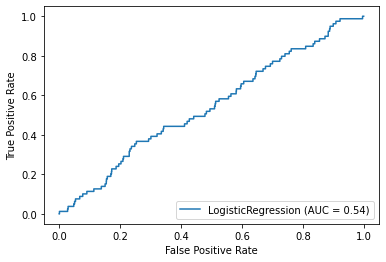

In [40]:
# ROC AUC
plot_roc_curve(best_clf, X_test, y_test);

# Random Forest Classifier

## First Run

In [41]:
# LR Classifier - First run

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

f1 = f1_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

note.loc[2] = ['RF Classifier - First Run', f1]
note

              precision    recall  f1-score   support

       False       0.98      1.00      0.99      3621
        True       0.00      0.00      0.00        79

    accuracy                           0.98      3700
   macro avg       0.49      0.50      0.49      3700
weighted avg       0.96      0.98      0.97      3700



,Model,F1
0,LR Classifier - First Run,0.000000
1,LR Classifier - Best Param,0.048849
2,RF Classifier - First Run,0.000000


### Confusion Matrix

In [42]:
# CM 

cm = confusion_matrix(y_test, y_pred, labels=[True, False])
cm = pd.DataFrame(cm, index=[True, False], columns=[True, False])
cm

,True,False
True,0,79
False,11,3610


## Grid Search

In [43]:
# Grid search - New my_param

my_param_grid = [{'min_samples_split': list(range(50, 220+1, 20))}]
my_param_grid

[{'min_samples_split': [50, 70, 90, 110, 130, 150, 170, 190, 210]}]

In [44]:
# Grid search - In action - **CV = 5**

clf = RandomForestClassifier(class_weight='balanced')
clf_gs = GridSearchCV(clf, my_param_grid, cv=5, scoring='f1')

clf_gs.fit(X_train, y_train)
best_MSS = clf_gs.best_estimator_.min_samples_split

best_MSS

170

In [45]:
# Grid Search - Checking measures 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      1.00      0.99      3621
        True       0.00      0.00      0.00        79

    accuracy                           0.98      3700
   macro avg       0.49      0.50      0.49      3700
weighted avg       0.96      0.98      0.97      3700



## Show off with the best Param

In [46]:
# Best Indicator

best_clf = RandomForestClassifier(n_estimators=100, bootstrap=False, class_weight='balanced', min_samples_split=best_MSS)

best_clf.fit(X_train, y_train)
y_pred = best_clf.predict(X_test)

f1 = f1_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

note.loc[3] = ['RF Classifier - Best Param', f1]
note

              precision    recall  f1-score   support

       False       0.98      0.83      0.90      3621
        True       0.03      0.25      0.06        79

    accuracy                           0.82      3700
   macro avg       0.51      0.54      0.48      3700
weighted avg       0.96      0.82      0.88      3700



,Model,F1
0,LR Classifier - First Run,0.000000
1,LR Classifier - Best Param,0.048849
2,RF Classifier - First Run,0.000000
3,RF Classifier - Best Param,0.057389


### Confusion Matrix

In [47]:
# CM

cm = confusion_matrix(y_test, y_pred, labels=[True, False])
cm = pd.DataFrame(cm, index=[True, False], columns=[True, False])
cm

,True,False
True,20,59
False,598,3023


## ROC_AUC

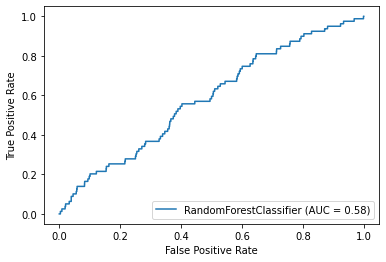

In [48]:
# ROC AUC
plot_roc_curve(best_clf, X_test, y_test);

1. More models
2. Gradient Descent
